# Signature-Based Two Sample Hypothesis Testing

## Mixture Models - Gradient Descent

### Andrew Alden

### Table of Contents

- [Initial Setup](#initial-setup)
- [Stochastic Process Setup](#process-setup)
- [Gradient Descent](#grad)
    - [Test 1](#grad-test1)
    - [Test 2](#grad-test2)

## Initial Setup <a class="anchor" id="initial-setup"></a>

### Change working directory to root folder

In [22]:
import os
os.getcwd()
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

### Import libraries 

In [23]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import pickle
from collections import defaultdict
from collections import Counter


from src.mmd.distribution_functions import return_mmd_distributions, expected_type2_error
from src.mmd.mmd import SigKernel, RBFKernel
from src.mmd.rbf_mmd import *
from src.mmd.type2_grad import *

In [4]:
import sys
import types

numpy_core_fake = types.ModuleType("numpy._core")
sys.modules["numpy._core"] = numpy_core_fake

numpy_core_fake.multiarray = np.core.multiarray
numpy_core_fake.numeric = np.core.numeric
numpy_core_fake.umath = np.core.umath

sys.modules["numpy._core.multiarray"] = np.core.multiarray
sys.modules["numpy._core.numeric"] = np.core.numeric
sys.modules["numpy._core.umath"] = np.core.umath

### Set device

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Stochastic Process Setup <a class="anchor" id="process-setup"></a>

In [11]:
def lead_lag_transformation(path):
    if type(path) == list:
        n = len(path)
    else:
        n = path.shape[1]
        
    dt = path[0, -1, 1]/(n-1) * 1/2
    
    lead_path = np.zeros((path.shape[0], path.shape[1]*2 + 1, path.shape[-1]))
    lag_path = np.zeros((path.shape[0], path.shape[1]*2 + 1, path.shape[-1]))
    
    for i in range(1, int(2*n)):
        
        if i % 2 == 0:            
            lead_path[:, i, :] = np.concatenate((path[:, int((i+2)/2 - 1), 0][:, None], (i-1)*dt*np.ones(path.shape[0])[:, None]), axis=1)
            lag_path[:, i, :] = np.concatenate((path[:, int(i/2 - 1), 0][:, None], (i-1)*dt*np.ones(path.shape[0])[:, None]), axis=1)
            
        else:
            lead_path[:, i, :] = np.concatenate((path[:, int((i+1)/2 - 1), 0][:, None], (i-1)*dt*np.ones(path.shape[0])[:, None]), axis=1)
            lag_path[:, i, :] = np.concatenate((path[:, int((i+1)/2 - 1), 0][:, None], (i-1)*dt*np.ones(path.shape[0])[:, None]), axis=1)

    lead_path[:, 0, :] = lead_path[:, 1, :]
    return lead_path[:, 1:-1, :], lag_path[:, 1:-1, :], np.concatenate((lead_path[:, 1:-1, :1], lag_path[:, 1:-1, :]), axis=2)

In [12]:
def ou_process(G0, theta, sigma, num_sim, num_time_steps, T):

    h = np.divide(T, num_time_steps)
    normal_rvs = np.sqrt(h)*np.random.normal(loc=0, scale=1, size=(num_time_steps, num_sim))
    G = np.ones((num_time_steps+1, num_sim))
    G[0, :] = np.ones(num_sim) * G0
    time_steps = [0]
    for i in range(1, num_time_steps+1):
        G[i, :] = G[i-1, :] * (1 - theta*h) + sigma*normal_rvs[i-1]
        time_steps.append(i*h)

    return np.concatenate((G[:, :, None], np.repeat(np.asarray(time_steps)[:, None, None], repeats=num_sim, axis=1)), axis=2)

def gbm_process(S0, mu, sigma, num_sim, num_time_steps, T):

    h = np.divide(T, num_time_steps)
    normal_rvs = np.sqrt(h)*np.random.normal(loc=0, scale=1, size=(num_time_steps, num_sim))
    S = np.ones((num_time_steps+1, num_sim))
    S[0, :] = np.ones(num_sim) * S0
    time_steps = [0]
    for i in range(1, num_time_steps+1):
        S[i, :] = S[i-1, :] * (1 + mu*h) + sigma*S[i-1, :]*normal_rvs[i-1]
        
        time_steps.append(i*h)

    return np.concatenate((S[:, :, None], np.repeat(np.asarray(time_steps)[:, None, None], repeats=num_sim, axis=1)), axis=2)

In [13]:
theta_1 = 0.3
theta_2 = theta_1

sigma_1 = 0.5
sigma_2 = 0.3

mu_tilde_1 = 0.5*sigma_1**2 + theta_2
mu_tilde_2 = 0.5*sigma_2**2 + theta_1


mu_1 = theta_2
mu_2 = theta_1

G0_1 = 0.75
G0_2 = 0.75

sigma_tilde_1 = np.sqrt(2*theta_2 * (np.exp(2*mu_tilde_2) - 2*G0_1 - G0_1**2 * np.exp(-2*theta_2)) * 1/(1 - np.exp(-2*theta_2)))
sigma_tilde_2 = np.sqrt(2*theta_1 * (np.exp(2*mu_tilde_1) - 2*G0_2 - G0_2**2 * np.exp(-2*theta_1)) * 1/(1 - np.exp(-2*theta_1)))


num_sim = 10000
T = 1.0
num_time_steps = 29


ou_paths_1 = ou_process(G0_1, theta_1, sigma_tilde_1, num_sim, num_time_steps, T)
gbm_paths_1 = gbm_process(1.0, mu_1, sigma_1, num_sim, num_time_steps, T)

ou_paths_2 = ou_process(G0_2, theta_2, sigma_tilde_2, num_sim, num_time_steps, T)
gbm_paths_2 = gbm_process(1.0, mu_2, sigma_2, num_sim, num_time_steps, T)

fact = 1.0
  
h0_paths = (2-fact)*ou_paths_1 + fact*gbm_paths_1
h0_paths[:, :, :] /= 2

h1_paths = (2-fact)*ou_paths_2 + fact*gbm_paths_2
h1_paths[:, :, :] /= 2

h0_paths = torch.transpose(torch.from_numpy(h0_paths), 1, 0).to(device=device)
h1_paths = torch.transpose(torch.from_numpy(h1_paths), 1, 0).to(device=device)

mean_h0 = torch.mean(h0_paths[:, -1, :1].squeeze(1))
std_h0 = torch.std(h0_paths[:, -1, :1].squeeze(1))

mean_h1 = torch.mean(h1_paths[:, -1, :1].squeeze(1))
std_h1 = torch.std(h1_paths[:, -1, :1].squeeze(1))

for i in range(num_sim):
    h0_paths[i, :, :1] = (h0_paths[i, :, :1] - mean_h0)/std_h0
    h1_paths[i, :, :1] = (h1_paths[i, :, :1] - mean_h1)/std_h1

h0_paths = torch.Tensor(lead_lag_transformation(np.asarray(h0_paths[:, :, :].cpu()))[-1]).to(device=device)
h1_paths = torch.Tensor(lead_lag_transformation(np.asarray(h1_paths[:, :, :].cpu()))[-1]).to(device=device)

## Gradient Descent <a class="anchor" id="grad"></a>

In [20]:
def mixture_model_gradient_descent(h0_paths, h1_paths, initial_scaling, lr, n_paths, n_atoms=100, thresh=1e-3,
                                   xi=10, alpha=0.05, rbf_sigma=0.1, maxiter=50, dyadic_order=0, 
                                   trunc_list=[1, 2, 4, 9, 11], estimator='b', num_sim=10, verbose=True, device='cpu'):
    
    
    grads_outer = []
    scalings_outer = []
    type2errors_outer = []
    
    error_fn = lambda x, y: expected_type2_error(torch.tensor(x), y).item()
    
    scaling = {}
    for i in trunc_list:
        scaling[i] = initial_scaling
        
    if verbose:
        itr = tqdm(range(num_sim))
    else:
        itr = range(num_sim)
    
    for _ in itr:
        
        
        grads = defaultdict(list)
        scalings = defaultdict(list)
        type2errors = defaultdict(list)
        
        for i in range(maxiter):
            
            for _k in trunc_list:
        
                static_kernel = RBFKernel(sigma=rbf_sigma, scaling=scaling[_k]**2)
                rbf_signature_kernel = SigKernel(static_kernel=static_kernel, dyadic_order=dyadic_order)
                
                h0_dists, h1_dists, rand_ints = return_mmd_distributions(
                    h0_paths, 
                    h1_paths, 
                    rbf_signature_kernel.compute_mmd, 
                    n_atoms=n_atoms, 
                    batch_size=n_paths, 
                    estimator=estimator, 
                    verbose=False
                )
                
                crit_val = np.sort(np.asarray(h0_dists))[int(n_atoms*(1-alpha))]
                
                error = error_fn(h1_dists, crit_val)
                type2errors[_k].append(error)
                
                if verbose:
                    print(f'Trunc Lvl: {_k}')
                    print(f'Error: {np.round(100 * error, 2)}%')
                    
                    
                new_scaling, done, grad = gradient_descent(h0_paths,
                                                   h1_paths, 
                                                   crit_val,
                                                   h1_dists, 
                                                   h0_dists,
                                                   xi, 
                                                   rand_ints,
                                                   scaling[_k], 
                                                   _k,
                                                   lr, 
                                                   thresh, 
                                                   i+1,
                                                   maxiter=maxiter, 
                                                   device=device, 
                                                   estimator=estimator, 
                                                   RBF=True, 
                                                   sigma=np.sqrt(rbf_sigma/2), 
                                                   verbose=False
                                                  )
                
                
                scaling[_k] = new_scaling
                grads[_k].append(grad)
                scalings[_k].append(scaling[_k])
                
            
            if verbose:
                print(scaling)
                print(f'i={i+1}')
            
                    
        grads_outer.append(grads)
        scalings_outer.append(scalings)
        type2errors_outer.append(type2errors)
        
    return grads_outer, scalings_outer, type2errors_outer

### Test 1 <a class="anchor" id="grad-test1"></a>

In [ ]:
lr_base = 0.01
lr = lambda i: lr_base * np.power(1/2, np.floor(i/15))
n_paths = 40
xi = 100
maxiter = 75
initial_scaling = 0.2

grads_outer, scalings_outer, type2errors_outer, mixture_model_gradient_descent(h0_paths, 
                                                                               h1_paths, 
                                                                               initial_scaling,
                                                                               lr,
                                                                               n_paths, 
                                                                               xi=xi,
                                                                               maxiter=maxiter,
                                                                               verbose=False,
                                                                               device=device)

Save Simulation.

In [ ]:
with open('MixtureData/grad_mixture_b_01_start1_rev_xi_100_fullsim', 'wb') as f:
    pickle.dump([scalings_outer, type2errors_outer, grads_outer], f)

Load Simulation. 

In [6]:
with open('MixtureData/grad_mixture_b_01_start1_rev_xi_100_fullsim', 'rb') as f:
    data = pickle.load(f)

scalings_outer = data[0]
type2errors_outer = data[1]
grads_outer = data[2]

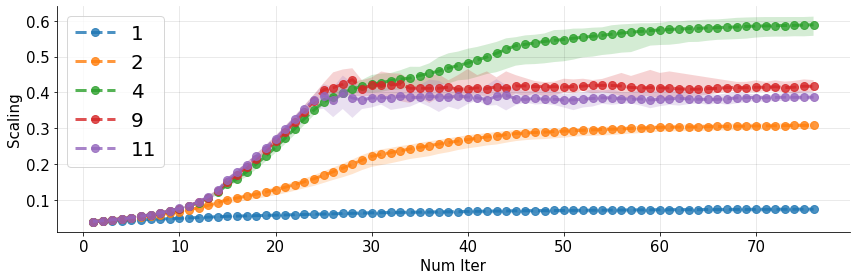

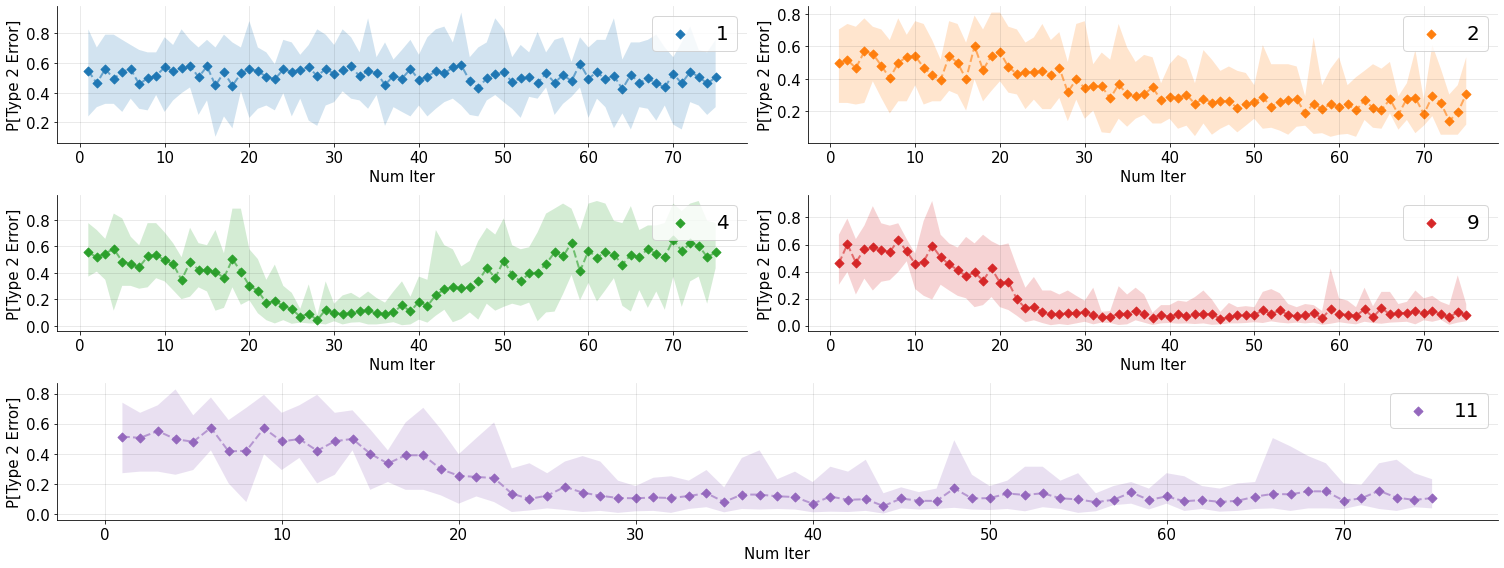

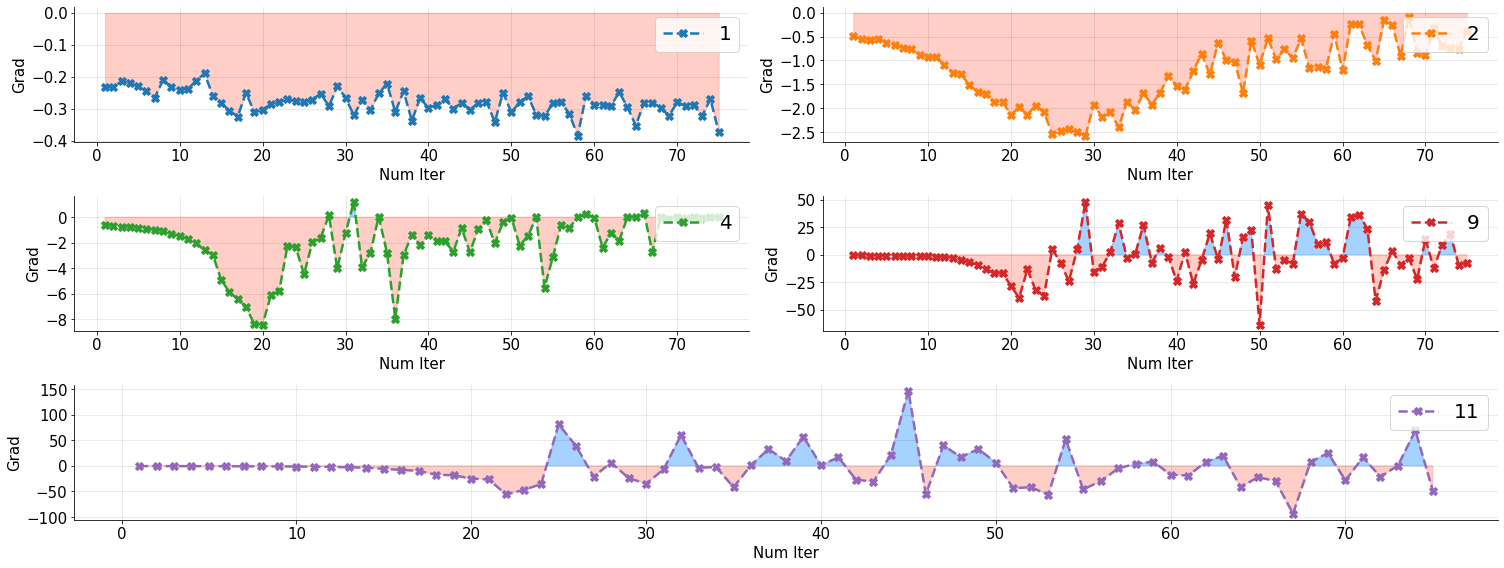

In [7]:
def change_ax_font(tick, fontsize):
    try:
        tick.label.set_fontsize(fontsize)
    except:
        try:
            tick.label1.set_fontsize(fontsize)
        except:
            pass


maxiter = 75

fig, ax = plt.subplots(figsize=(12, 4))
colors = []
for _k in [1, 2, 4, 9, 11]:
    
    data_matrix = np.power([[0.2]+scalings_outer[i][_k] for i in range(10)], 2)
    mean_scalings = np.mean(data_matrix, axis=0)
    min_scalings = np.min(data_matrix, axis=0)
    max_scalings = np.max(data_matrix, axis=0)
    line = ax.plot(range(1, maxiter+2), mean_scalings, linewidth=3.0, marker='o', linestyle='--', markersize=8, alpha=0.8, label=f'{_k}')
    ax.fill_between(range(1, maxiter+2), min_scalings, max_scalings, color=line[0].get_color(), alpha=0.2, edgecolor='none')
    colors.append(line[0].get_color())
    
ax.set_ylabel('Scaling', fontsize=15)
ax.set_xlabel('Num Iter', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc='upper left', fontsize=20)
ax.grid(True, color='black', alpha=0.1)

for tick in ax.xaxis.get_major_ticks():
    change_ax_font(tick, 15)
for tick in ax.yaxis.get_major_ticks():
    change_ax_font(tick, 15)

plt.tight_layout()
filename = f'MixtureModelImages/gradient_descent_scaling_trunclvls_xi_100_fullsim.svg'
file_path = Path(filename)
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()



fig = plt.figure(figsize=(21, 8))

gs = gridspec.GridSpec(3, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])  
ax2 = fig.add_subplot(gs[0, 1])  
ax3 = fig.add_subplot(gs[1, 0])  
ax4 = fig.add_subplot(gs[1, 1])  
ax5 = fig.add_subplot(gs[2, 0:3])

ax = np.asarray([[ax1, ax2, ax3], [ax4, ax5, None]])
for i, _k in enumerate([1, 2, 4, 9, 11]):

    if i == 0:
        j = 0
        k = 0
    elif i == 1:
        j = 0
        k = 1
    elif i == 2:
        j = 0
        k = 2
    elif i == 3:
        j = 1
        k = 0
    elif i == 4:
        j = 1
        k = 1
    else:
        j = 1
        k = 2

    data_matrix = np.power([type2errors_outer[i][_k] for i in range(10)], 2)
    mean_error = np.mean(data_matrix, axis=0)
    min_error = np.min(data_matrix, axis=0)
    max_error = np.max(data_matrix, axis=0)
    
    ax[j, k].plot(range(1, maxiter+1), mean_error, linewidth=2.0, linestyle='--', alpha=0.6, color=colors[i])
    ax[j, k].scatter(range(1, maxiter+1), mean_error, marker='D', s=40, color=colors[i], label=f'{_k}')
    ax[j, k].fill_between(range(1, maxiter+1), min_error, max_error, color=colors[i], alpha=0.2, edgecolor='none')
    ax[j, k].set_ylabel('P[Type 2 Error]', fontsize=15)
    ax[j, k].set_xlabel('Num Iter', fontsize=15)
    ax[j, k].spines['right'].set_visible(False)
    ax[j, k].spines['top'].set_visible(False)
    ax[j, k].legend(loc='upper right', fontsize=20)
    ax[j, k].grid(True, color='black', alpha=0.1)
    
    for tick in ax[j, k].xaxis.get_major_ticks():
        change_ax_font(tick, 15)
    for tick in ax[j, k].yaxis.get_major_ticks():
        change_ax_font(tick, 15)

plt.tight_layout()
filename = f'MixtureModelImages/gradient_descent_error_trunclvls_xi_100_fullsim.svg'
file_path = Path(filename)
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()


fig = plt.figure(figsize=(21, 8))

gs = gridspec.GridSpec(3, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])  
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])  
ax5 = fig.add_subplot(gs[2, 0:3])  

ax = np.asarray([[ax1, ax2, ax3], [ax4, ax5, None]])
    
line_formula = lambda y, y1, y2, x1: (y-y1)/(y2-y1) + x1

for i, _k in enumerate([1, 2, 4, 9, 11]):

    if i == 0:
        j = 0
        k = 0
    elif i == 1:
        j = 0
        k = 1
    elif i == 2:
        j = 0
        k = 2
    elif i == 3:
        j = 1
        k = 0
    elif i == 4:
        j = 1
        k = 1
    else:
        j = 1
        k = 2


    ax[j, k].plot(range(1, maxiter+1), grads_outer[0][_k], linewidth=2.5, marker='X', linestyle='--', markersize=8, label=f'{_k}', color=colors[i])
    ax[j, k].set_ylabel('Grad', fontsize=15)
    ax[j, k].set_xlabel('Num Iter', fontsize=15)
    ax[j, k].legend(loc='upper right', fontsize=20)



    dummy_grads = grads_outer[0][_k].copy()
    index = 0
    t = 1
    time_index = []
    while index < len(dummy_grads)-1:
        time_index.append(t)
        if np.sign(dummy_grads[index]) != np.sign(dummy_grads[index+1]):
            if np.sign(dummy_grads[index]) == np.sign(-1):
                val = -1e-10
            else:
                val = 1e-10
            dummy_grads = dummy_grads[:index+1] + [val, -val] + dummy_grads[index+1:]
        
            time_index.append(line_formula(val, dummy_grads[index], dummy_grads[index+3], t))
            time_index.append(line_formula(-val, dummy_grads[index], dummy_grads[index+3], t))
    
            index += 3
        else: 
            index += 1
        t += 1
    
    time_index.append(t)
    
    ax[j, k].fill_between(time_index, 0, dummy_grads,
                     where = np.asarray(dummy_grads) >= 0,
                     color = 'dodgerblue', alpha=0.4)
    ax[j, k].fill_between(time_index, dummy_grads, 0,
                     where = np.asarray(dummy_grads) <= 0,
                     color = 'tomato', alpha=0.3)

    ax[j, k].spines['right'].set_visible(False)
    ax[j, k].spines['top'].set_visible(False)
    ax[j, k].grid(True, color='black', alpha=0.1)
    
    for tick in ax[j, k].xaxis.get_major_ticks():
        change_ax_font(tick, 15)
    for tick in ax[j, k].yaxis.get_major_ticks():
        change_ax_font(tick, 15)


plt.tight_layout()
filename = f'MixtureModelImages/gradient_descent_grad_trunclvls_xi_100_fullsim.svg'
file_path = Path(filename)
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

### Test 2 <a class="anchor" id="grad-test2"></a>

In [ ]:
lr_base = 0.01
lr = lambda i: lr_base * np.power(1/2, np.floor(i/15))
n_paths = 40
xi = 10
maxiter = 50
initial_scaling = 0.8

grads_outer, scalings_outer, type2errors_outer, mixture_model_gradient_descent(h0_paths, 
                                                                               h1_paths, 
                                                                               initial_scaling,
                                                                               lr,
                                                                               n_paths, 
                                                                               xi=xi,
                                                                               maxiter=maxiter,
                                                                               verbose=False,
                                                                               device=device)

Save Simulation.

In [ ]:
with open('MixtureData/grad_mixture_b_01_start1_xi_10_fullsim', 'wb') as f:
    pickle.dump([scalings_outer, type2errors_outer, grads_outer], f)

Load Simulation. 

In [8]:
with open('MixtureData/grad_mixture_b_01_start1_xi_10_fullsim', 'rb') as f:
    data = pickle.load(f)

scalings_outer = data[0]
type2errors_outer = data[1]
grads_outer = data[2]

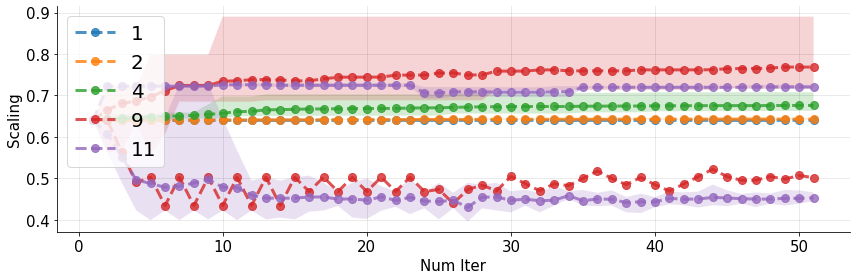

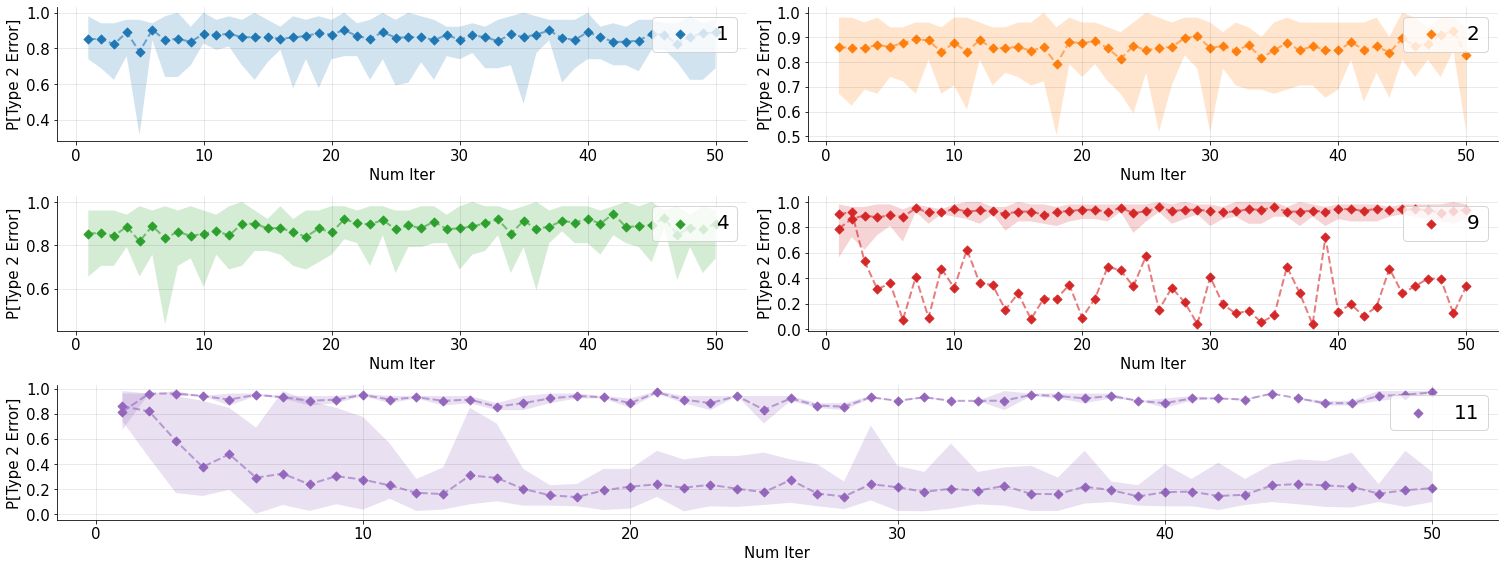

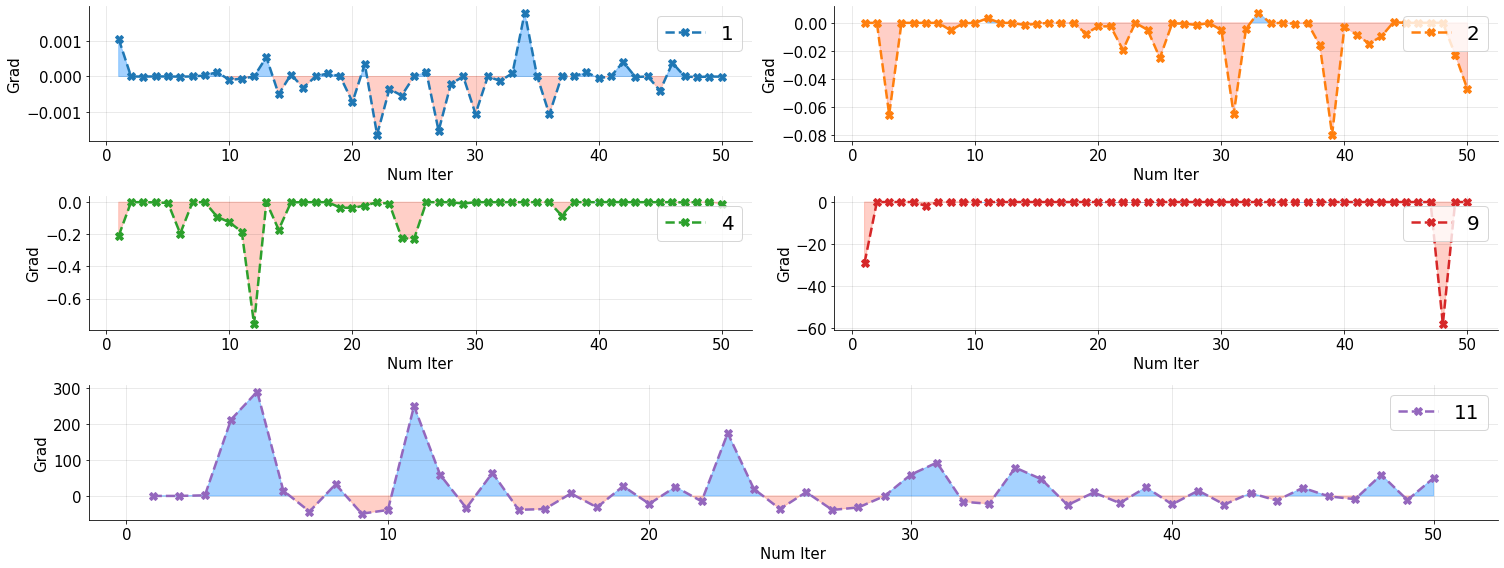

In [10]:
def change_ax_font(tick, fontsize):
    try:
        tick.label.set_fontsize(fontsize)
    except:
        try:
            tick.label1.set_fontsize(fontsize)
        except:
            pass

maxiter = 50

colors = []

fig, ax = plt.subplots(figsize=(12, 4))

for i, _k in enumerate([1, 2, 4, 9, 11]):

    if i == 0:
        j = 0
        k = 0
    elif i == 1:
        j = 0
        k = 1
    elif i == 2:
        j = 0
        k = 2
    elif i == 3:
        j = 1
        k = 0
    elif i == 4:
        j = 1
        k = 1
    else:
        j = 1
        k = 2
    
    data_matrix = np.power([[0.8]+scalings_outer[i][_k] for i in range(10)], 2)
    mean_scalings = np.mean(data_matrix, axis=0)
    line = ax.plot(range(1, maxiter+2), mean_scalings, alpha=0.0)
    colors.append(line[0].get_color())

    if _k <= 4:
        mean_scalings = np.mean(data_matrix, axis=0)
        min_scalings = np.min(data_matrix, axis=0)
        max_scalings = np.max(data_matrix, axis=0)
        ax.plot(range(1, maxiter+2), mean_scalings, linewidth=3.0, marker='o', linestyle='--', 
                             markersize=8, alpha=0.8, label=f'{_k}', color=line[0].get_color())
        ax.fill_between(range(1, maxiter+2), min_scalings, max_scalings, color=line[0].get_color(), alpha=0.2, edgecolor='none')
        
    else:

        converge_indices = np.where(data_matrix[:, -1] < 0.6)[0]
        not_converge_indices = np.setdiff1d(np.asarray(range(10)), converge_indices)

        data_matrix_converge = data_matrix[converge_indices, :]
        mean_error_converge = np.mean(data_matrix_converge, axis=0)
        min_error_converge = np.min(data_matrix_converge, axis=0)
        max_error_converge = np.max(data_matrix_converge, axis=0)

        data_matrix_not_converge = data_matrix[not_converge_indices, :]
        mean_error_not_converge = np.mean(data_matrix_not_converge, axis=0)
        min_error_not_converge = np.min(data_matrix_not_converge, axis=0)
        max_error_not_converge = np.max(data_matrix_not_converge, axis=0)

        ax.plot(range(1, maxiter+2), mean_error_converge, linewidth=3.0, marker='o',
                             linestyle='--', markersize=8, alpha=0.8, label=f'{_k}', color=line[0].get_color())
        ax.fill_between(range(1, maxiter+2), min_error_converge, max_error_converge, 
                              color=line[0].get_color(), alpha=0.2, edgecolor='none')

        ax.plot(range(1, maxiter+2), mean_error_not_converge, linewidth=3.0, marker='o', 
                             linestyle='--', markersize=8, alpha=0.8, color=line[0].get_color())
        ax.fill_between(range(1, maxiter+2), min_error_not_converge, max_error_not_converge, color=line[0].get_color(), 
                              alpha=0.2, edgecolor='none')

        

        
    
    ax.set_ylabel('Scaling', fontsize=15)
    ax.set_xlabel('Num Iter', fontsize=15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(loc='upper left', fontsize=20)
    ax.grid(True, color='black', alpha=0.1)
    
    for tick in ax.xaxis.get_major_ticks():
        change_ax_font(tick, 15)
    for tick in ax.yaxis.get_major_ticks():
        change_ax_font(tick, 15)

plt.tight_layout()
filename = f'MixtureModelImages/gradient_descent_scaling_trunclvls_xi_100_fullsim_rev.svg'
file_path = Path(filename)
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()



fig = plt.figure(figsize=(21, 8))

gs = gridspec.GridSpec(3, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])  
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])  
ax5 = fig.add_subplot(gs[2, 0:3]) 

ax = np.asarray([[ax1, ax2, ax3], [ax4, ax5, None]])
for i, _k in enumerate([1, 2, 4, 9, 11]):

    if i == 0:
        j = 0
        k = 0
    elif i == 1:
        j = 0
        k = 1
    elif i == 2:
        j = 0
        k = 2
    elif i == 3:
        j = 1
        k = 0
    elif i == 4:
        j = 1
        k = 1
    else:
        j = 1
        k = 2

    data_matrix = np.power([type2errors_outer[i][_k] for i in range(10)], 2)
    mean_error = np.mean(data_matrix, axis=0)
    min_error = np.min(data_matrix, axis=0)
    max_error = np.max(data_matrix, axis=0)

    if _k <= 4:
        ax[j, k].plot(range(1, maxiter+1), mean_error, linewidth=2.0, linestyle='--', alpha=0.6, color=colors[i])
        ax[j, k].scatter(range(1, maxiter+1), mean_error, marker='D', s=40, color=colors[i], label=f'{_k}')
        ax[j, k].fill_between(range(1, maxiter+1), min_error, max_error, color=colors[i], alpha=0.2, edgecolor='none')
    else:

        converge_indices = np.where(data_matrix[:, -1] < 0.75)[0]
        not_converge_indices = np.setdiff1d(np.asarray(range(10)), converge_indices)

        data_matrix_converge = data_matrix[converge_indices, :]
        mean_error_converge = np.mean(data_matrix_converge, axis=0)
        min_error_converge = np.min(data_matrix_converge, axis=0)
        max_error_converge = np.max(data_matrix_converge, axis=0)

        data_matrix_not_converge = data_matrix[not_converge_indices, :]
        mean_error_not_converge = np.mean(data_matrix_not_converge, axis=0)
        min_error_not_converge = np.min(data_matrix_not_converge, axis=0)
        max_error_not_converge = np.max(data_matrix_not_converge, axis=0)

        ax[j, k].plot(range(1, maxiter+1), mean_error_converge, linewidth=2.0, linestyle='--', alpha=0.6, color=colors[i])
        ax[j, k].scatter(range(1, maxiter+1), mean_error_converge, marker='D', s=40, color=colors[i], label=f'{_k}')
        ax[j, k].fill_between(range(1, maxiter+1), min_error_converge, max_error_converge, color=colors[i], 
                              alpha=0.2, edgecolor='none')

        ax[j, k].plot(range(1, maxiter+1), mean_error_not_converge, linewidth=2.0, linestyle='--', alpha=0.6, color=colors[i])
        ax[j, k].scatter(range(1, maxiter+1), mean_error_not_converge, marker='D', s=40, color=colors[i])
        ax[j, k].fill_between(range(1, maxiter+1), min_error_not_converge, max_error_not_converge, color=colors[i], 
                              alpha=0.2, edgecolor='none')
        
    ax[j, k].set_ylabel('P[Type 2 Error]', fontsize=15)
    ax[j, k].set_xlabel('Num Iter', fontsize=15)
    ax[j, k].spines['right'].set_visible(False)
    ax[j, k].spines['top'].set_visible(False)
    ax[j, k].legend(loc='upper right', fontsize=20)
    ax[j, k].grid(True, color='black', alpha=0.1)
    
    for tick in ax[j, k].xaxis.get_major_ticks():
        change_ax_font(tick, 15)
    for tick in ax[j, k].yaxis.get_major_ticks():
        change_ax_font(tick, 15)

plt.tight_layout()
filename = f'MixtureModelImages/gradient_descent_error_trunclvls_xi_100_fullsim_rev.svg'
file_path = Path(filename)
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()



fig = plt.figure(figsize=(21, 8))

gs = gridspec.GridSpec(3, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])  
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])  
ax5 = fig.add_subplot(gs[2, 0:3])  

ax = np.asarray([[ax1, ax2, ax3], [ax4, ax5, None]])
    
line_formula = lambda y, y1, y2, x1: (y-y1)/(y2-y1) + x1

for i, _k in enumerate([1, 2, 4, 9, 11]):

    if i == 0:
        j = 0
        k = 0
    elif i == 1:
        j = 0
        k = 1
    elif i == 2:
        j = 0
        k = 2
    elif i == 3:
        j = 1
        k = 0
    elif i == 4:
        j = 1
        k = 1
    else:
        j = 1
        k = 2


    ax[j, k].plot(range(1, maxiter+1), grads_outer[0][_k], linewidth=2.5, marker='X', linestyle='--', markersize=8, label=f'{_k}', color=colors[i])
    ax[j, k].set_ylabel('Grad', fontsize=15)
    ax[j, k].set_xlabel('Num Iter', fontsize=15)
    ax[j, k].legend(loc='upper right', fontsize=20)



    # if _k in [1, 2, 11]:
    dummy_grads = grads_outer[0][_k].copy()
    index = 0
    t = 1
    time_index = []
    while index < len(dummy_grads)-1:
        time_index.append(t)
        if np.sign(dummy_grads[index]) != np.sign(dummy_grads[index+1]):
            if np.sign(dummy_grads[index]) == np.sign(-1):
                val = -1e-10
            else:
                val = 1e-10
            dummy_grads = dummy_grads[:index+1] + [val, -val] + dummy_grads[index+1:]
        
            time_index.append(line_formula(val, dummy_grads[index], dummy_grads[index+3], t))
            if np.abs(time_index[-1]) > 1000:
                time_index[-1] = time_index[-2]
            time_index.append(line_formula(-val, dummy_grads[index], dummy_grads[index+3], t))
            if np.abs(time_index[-1]) > 1000:
                time_index[-1] = time_index[-2]
    
            index += 3
        else: 
            index += 1
        t += 1
    
    time_index.append(t)
    
    ax[j, k].fill_between(time_index, 0, dummy_grads,
                     where = np.asarray(dummy_grads) >= 0,
                     color = 'dodgerblue', alpha=0.4)
    ax[j, k].fill_between(time_index, dummy_grads, 0,
                     where = np.asarray(dummy_grads) <= 0,
                     color = 'tomato', alpha=0.3)

    ax[j, k].spines['right'].set_visible(False)
    ax[j, k].spines['top'].set_visible(False)
    ax[j, k].grid(True, color='black', alpha=0.1)
    
    for tick in ax[j, k].xaxis.get_major_ticks():
        change_ax_font(tick, 15)
    for tick in ax[j, k].yaxis.get_major_ticks():
        change_ax_font(tick, 15)


plt.tight_layout()
filename = f'MixtureModelImages/gradient_descent_grad_trunclvls_xi_100_fullsim_rev.svg'
file_path = Path(filename)
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()